# Load data and libraries

In [1]:
# accessing data from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/brain-tumor-segmentation-brats-2019.zip

Archive:  gdrive/My Drive/brain-tumor-segmentation-brats-2019.zip
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_flair.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_seg.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t1.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t1ce.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t2.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_flair.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_seg.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_t1.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_t1ce.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2

In [3]:
pip install opendatasets

In [4]:
pip install pandas

In [5]:
# medical image processing
!pip install medpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.2/156.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 30.0 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.5.1-cp310-cp310-linux_x86_64.whl size=762858 sha256=3a1532cf91eddab4bae05e7b82adf190eee702d804db54b55552ce85d6fb8a30
  Stored in directory: /root/.cache/pip/wheels/e6/8f/f9/7fec657d34ad3ebd2ea3ca5ad0e526f8fea93c3fb4a26c3416
Successfully built medpy


In [6]:
# neuroimaging data processing
!pip install nibabel

In [7]:
# tools for working with NIfTI images (visualization, etc.)
!pip install nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 97.3 MB/s eta 0:00:00


In [8]:
!pip install pybids

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=98a12f5356fb4883cb39899158938995520741ac19693d99e94e2b2111ccc451
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [9]:
import opendatasets as od
import pandas as pd
import seaborn as sns
import numpy as np
import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import glob #going through all files
import re #for filepaths

In [10]:
# reads survival data (patient ID, age, survival, resection status) into dataframe
csv_df = pd.read_csv("/content/MICCAI_BraTS_2019_Data_Training/survival_data.csv")

# Constructing dataframe

In [11]:
# print(df['ResectionStatus'].unique()), standardizes resection status into numerical value
from sklearn.preprocessing import LabelEncoder

# GTR = 0, STR = 1, NaN = 2
le = LabelEncoder()
le.fit(csv_df["ResectionStatus"])
csv_df["ResectionNum"] = le.transform(csv_df["ResectionStatus"])

# cleaning null values
def convert_to_numeric(value):
    try:
        return float(value)
    except (ValueError, TypeError):
        return 0
csv_df["Survival"] = csv_df["Survival"].apply(convert_to_numeric)
csv_df.dropna(subset=["Age"], inplace=True)
csv_df.dropna(subset=["Survival"], inplace=True)

In [12]:
#creates list of all flair_files filepaths
flair_files = glob.glob("/content/MICCAI_BraTS_2019_Data_Training/HGG/*/*_flair.nii")
print(len(flair_files))

259


In [13]:
master_df = pd.DataFrame({
    'Patient_ID': [''],
    'Survival': [''],
    'MRI': ['']
})

for flair_file in flair_files:

  # one slice of .nii file
  hgg_load = nib.load(flair_file).get_data()
  load_slice = hgg_load[:,:,120]

  # 'Patient_ID' from file name
  pattern = r"/([^/]+)/([^/]+)_flair\.nii"

  match = re.search(pattern, flair_file)

  if match:
      patient_id = match.group(2)

  # get 'Survival' value for corresponding Patient ID from .csv
  survival_value = csv_df.loc[csv_df['BraTS19ID'] == patient_id, 'Survival'].values
  master_df.loc[len(master_df)] = [patient_id, survival_value, load_slice]

master_df = master_df.drop(0) #extra row on top

<ipython-input-13-d7affafc925a>:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  hgg_load = nib.load(flair_file).get_data()
<ipython-input-13-d7affafc925a>:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  hgg_load = nib.load(flair_file).get_data()
<ipython-input-13-d7affafc925a>:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.da

In [14]:
# drop rows with empty arrays in the "Survival" column
master_df['Survival'] = master_df['Survival'].apply(lambda x: x if len(x) > 0 else None)
master_df = master_df.dropna(subset=['Survival'], axis=0)

# reset the index after dropping rows
master_df = master_df.reset_index(drop=True)

In [15]:
master_df.head(5)

,Patient_ID,Survival,MRI
0,BraTS19_TCIA01_235_1,[804.0],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,BraTS19_CBICA_BHQ_1,[336.0],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,BraTS19_CBICA_BBG_1,[112.0],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,BraTS19_CBICA_ALX_1,[698.0],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,BraTS19_CBICA_AYW_1,[734.0],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [16]:
master_df.shape

(212, 3)

In [17]:
average_value = master_df[['Survival']].mean()
print(average_value)

Survival    433.259434
dtype: object


# CNN

In [18]:
import tensorflow as tf

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [20]:
# extract image data
X = np.array(master_df['MRI'].to_list())


In [21]:
# extract survival data
y = np.concatenate(master_df['Survival'])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
# check the target variable type and shape
print(type(y_train), y_train.shape)
print(type(X_train), X_train.shape)

<class 'numpy.ndarray'> (159,)
<class 'numpy.ndarray'> (159, 240, 240)


In [23]:


  # reshape the data for ImageDataGenerator (add dimension for channels)
  X_train = np.expand_dims(X_train, axis=-1)
  X_test = np.expand_dims(X_test, axis=-1)

  # flatten the 3D array to 2D for StandardScaler
  X_train_flat = X_train.reshape(X_train.shape[0], -1)
  X_test_flat = X_test.reshape(X_test.shape[0], -1)

  # preprocess the data using StandardScaler
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train_flat)
  X_test_scaled = scaler.transform(X_test_flat)

  # reshape the data back to 3D for compatibility with Conv2D layer
  X_train_scaled = X_train_scaled.reshape(X_train.shape)
  X_test_scaled = X_test_scaled.reshape(X_test.shape)

  # reshape y_test and y_train for compatibility
  y_test_reshaped = y_test.reshape(y_test.shape[0], -1, 1)
  y_train_reshaped = y_train.reshape(y_train.shape[0], -1, 1)

  # CNN model
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(240, 240, 1)))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='linear'))  # survival = regression task

  model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

In [24]:
# fit model and run on test
history = model.fit(X_train_scaled, y_train_reshaped, epochs=10, batch_size=60, validation_data=(X_test_scaled, y_test_reshaped))

Epoch 1/10
3/3 [==============================] - 23s 5s/step - loss: 394.3437 - mae: 394.3437 - val_loss: 326.7249 - val_mae: 326.7249
Epoch 2/10
3/3 [==============================] - 1s 247ms/step - loss: 301.2192 - mae: 301.2192 - val_loss: 353.1245 - val_mae: 353.1245
Epoch 3/10
3/3 [==============================] - 1s 241ms/step - loss: 284.0524 - mae: 284.0524 - val_loss: 291.8547 - val_mae: 291.8547
Epoch 4/10
3/3 [==============================] - 1s 241ms/step - loss: 281.5773 - mae: 281.5773 - val_loss: 274.8641 - val_mae: 274.8641
Epoch 5/10
3/3 [==============================] - 1s 240ms/step - loss: 265.7545 - mae: 265.7545 - val_loss: 288.9379 - val_mae: 288.9379
Epoch 6/10
3/3 [==============================] - 1s 242ms/step - loss: 261.8827 - mae: 261.8827 - val_loss: 282.5028 - val_mae: 282.5028
Epoch 7/10
3/3 [==============================] - 1s 239ms/step - loss: 250.5958 - mae: 250.5958 - val_loss: 266.7979 - val_mae: 266.7979
Epoch 8/10
3/3 [====================

# Evaluation

In [25]:
from statistics import mean, pstdev

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
predicted_values = model.predict(X_test_scaled)

2/2 [==============================] - 3s 1s/step


In [28]:
y_test = y_test.tolist()

In [29]:
mse = mean_squared_error(predicted_values, y_test)
print(mse)

132187.13824857396


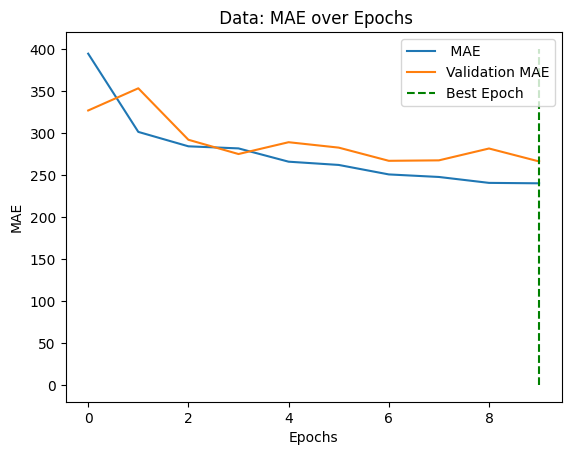

In [30]:
# Plot the MAE graph
plt.plot(history.history['mae'], label=' MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title(' Data: MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')

history_history = history.history
history_history.update({'epoch':list(range(len(history_history['val_mae'])))})
history_df = pd.DataFrame.from_dict(history_history)

best_epoch = history_df.sort_values(by = 'val_mae', ascending = True).iloc[0]['epoch']
plt.vlines(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch', ymin = 0, ymax = 400)
plt.legend()
plt.show()

